# #6 Two-level recommendation models

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

print('Done')

Done


In [44]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../features_data/product.csv')
user_features = pd.read_csv('../features_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)] # давние покупки
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

In [5]:
user_features.shape, item_features.shape

((801, 8), (92353, 7))

In [6]:
print('data_train_lvl_1: {}-{} weeks'.format(data_train_lvl_1.week_no.min(), data_train_lvl_1.week_no.max()))
print('data_val_lvl_1: {}-{} weeks'.format(data_val_lvl_1.week_no.min(), data_val_lvl_1.week_no.max()))

print('data_train_lvl_2: {}-{} weeks'.format(data_train_lvl_2.week_no.min(), data_train_lvl_2.week_no.max()))
print('data_val_lvl_2: {}-{} weeks'.format(data_val_lvl_2.week_no.min(), data_val_lvl_2.week_no.max()))

data_train_lvl_1: 1-85 weeks
data_val_lvl_1: 86-91 weeks
data_train_lvl_2: 86-91 weeks
data_val_lvl_2: 92-95 weeks


In [7]:
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features, 5000)

== Starting prefilter info ==
shape: (2108779, 12)
# users: 2498
# items: 83685
Sparsity: 1.009%
== Ending prefilter info ==
shape: (600870, 13)
# users: 2471
# items: 5000
Sparsity: 4.863%
new_columns: {'price'}


In [8]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
def get_recommendations(user, model, N):
    if model == 'als':
        return recommender.get_als_recommendations(user, N=N)
    elif model == 'own':
        return recommender.get_own_recommendations(user, N=N)
    elif model == 'similar_items':
        return recommender.get_similar_items_recommendation(user, N=N)
    elif model == 'similar_users':
        return recommender.get_similar_users_recommendation(user, N=N)

In [22]:
train_users = data_train_lvl_1['user_id'].unique()

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(train_users)] 
result_lvl_1 = data_val_lvl_1.groupby('user_id').item_id.unique().reset_index(name='actual')

result_lvl_1.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


In [24]:
for name in ('als','own','similar_items', 'similar_users'):
    result_lvl_1[name] = result_lvl_1['user_id'].apply(lambda x: get_recommendations(x, name, N=5))

In [71]:
result_lvl_1.head()

,user_id,actual,als,own,similar_items,similar_users
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[854852, 9526410, 904360, 961554, 962568]","[904360, 883404, 951590, 1133018, 961554]","[991580, 9677886, 1042564, 825616, 945139]","[904360, 883404, 951590, 1133018, 961554]"
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1133018, 951590, 904360, 923746, 1068719]","[904360, 883404, 951590, 1133018, 961554]","[1106523, 960318, 1031697, 1127025, 999730]","[904360, 883404, 951590, 1133018, 961554]"
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[951590, 962229, 904360, 873627, 826249]","[904360, 883404, 951590, 1133018, 961554]","[1048462, 1119454, 943393, 1100552, 1131974]","[904360, 883404, 951590, 1133018, 961554]"
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[903325, 962568, 1024306, 961554, 845208]","[904360, 883404, 951590, 1133018, 961554]","[874149, 904360, 6632481, 923746, 889731]","[904360, 883404, 951590, 1133018, 961554]"
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[961554, 987724, 883404, 828867, 904360]","[844165, 904360, 883404, 951590, 1133018]","[821007, 1094955, 835243, 6551990, 1072009]","[904360, 883404, 951590, 1133018, 961554]"


### **`Testing different values of @N`**

In [26]:
users_lvl_1['candidates'] = users_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 100))

In [27]:
users_lvl_1

,user_id,candidates
0,2070,"[904360, 883404, 951590, 1133018, 961554, 9237..."
1,2021,"[904360, 883404, 951590, 1133018, 961554, 9237..."
2,1753,"[904360, 883404, 951590, 1133018, 961554, 9237..."
3,2120,"[904360, 883404, 951590, 1133018, 961554, 9237..."
4,1346,"[904360, 883404, 951590, 1133018, 961554, 9237..."
...,...,...
2126,1446,"[904360, 883404, 951590, 1133018, 961554, 9237..."
2127,1784,"[904360, 883404, 951590, 1133018, 961554, 9237..."
2128,436,"[904360, 883404, 951590, 1133018, 961554, 9237..."
2129,1697,"[904360, 883404, 951590, 1133018, 961554, 9237..."


In [ ]:
rk_result = {}
train_users = data_train_lvl_1['user_id'].unique()

item_ids_by_users = data_val_lvl_1.groupby('user_id').item_id.unique().reset_index()
item_ids_by_users.columns = ['user_id', 'actual']
users_lvl_1 = pd.DataFrame(data_val_lvl_1['user_id'].unique())
users_lvl_1.columns = ['user_id']
users_lvl_1 = users_lvl_1[users_lvl_1.user_id.isin(train_users)]

users_lvl_1['candidates'] = users_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 100))

for k in (5, 10, 20, 50, 100):
    m = np.mean([recall_at_k(a, p, k=k) for a,p in zip(item_ids_by_users['actual'].tolist(), users_lvl_1['candidates'].tolist())])
    rk_result[k] = m

In [33]:
mark_df = pd.DataFrame.from_dict(rk_result, orient='index').reset_index()
mark_df.columns = ['k', 'average_recall']
mark_df

,k,average_recall
0,5,0.005675
1,10,0.009909
2,20,0.017128
3,50,0.031858
4,100,0.044504


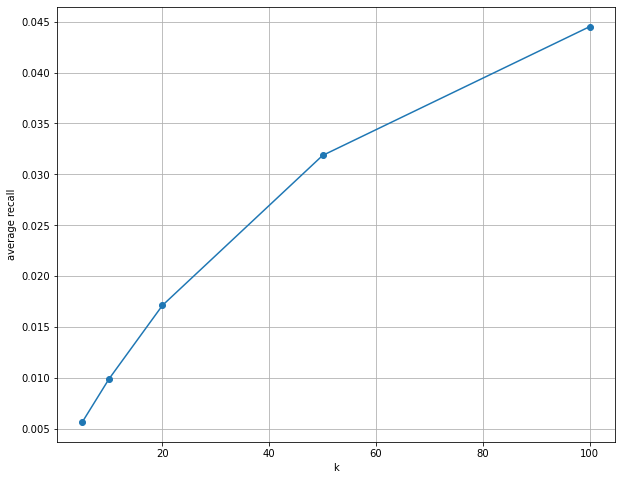

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(mark_df.k, mark_df.average_recall, marker='o')
plt.ylabel(ylabel='average recall')
plt.xlabel(xlabel='k')
plt.grid(True)
plt.show()

### **`Testing various number of weeks for validation datasample`**

In [10]:
data_split_size_to_recall = {}
for size_weeks in range(1, 12):
    data_val_lvl1 = data[(data['week_no'] >= data['week_no'].max() - (size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]
    
    users = pd.DataFrame(data_val_lvl1['user_id'].unique())
    users.columns = ['user_id']

    users = users[users.user_id.isin(train_users)]

    item_ids_by_users = data_val_lvl1.groupby('user_id').item_id.unique().reset_index()
    item_ids_by_users.columns = ['user_id', 'actual']

    users['candidates'] = users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    m = np.mean([recall_at_k(a, p) for a,p in zip(item_ids_by_users['actual'].tolist(), users['candidates'].tolist())])
    data_split_size_to_recall[size_weeks] = m

data_split_size_to_recall

{1: 0.0011654556302480123,
 2: 0.0014292209235736977,
 3: 0.001495902692337063,
 4: 0.001577515108396672,
 5: 0.0013590916715392081,
 6: 0.0017560665771922854,
 7: 0.001600243550731298,
 8: 0.0018135687676887583,
 9: 0.0015296008536488607,
 10: 0.0018071378066584905,
 11: 0.0017504041589370546}

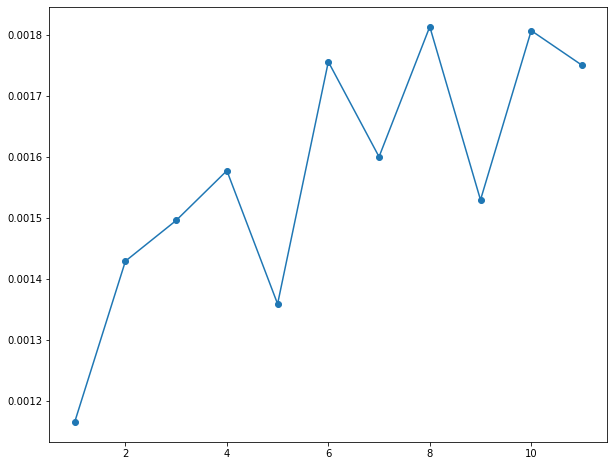

In [11]:
mark_df = pd.DataFrame.from_dict(data_split_size_to_recall, orient='index').reset_index()
mark_df.columns = ['weeks_num', 'mean_average_recall']

plt.figure(figsize=(10, 8))
plt.plot(mark_df.weeks_num, mark_df.mean_average_recall, marker='o')

plt.show()

### **`Prepare validation users (warm start without new customers)`**

In [38]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

### **`Create new user features`**

`- purchase frequency by one month`

`- purchases number on each of the department`

In [39]:
# User new feature:
#   "purchase frequency by one month"
def merge_purchase_freq_by_month(user_features, data):
    data = data[data.user_id.isin(user_features.user_id.unique().tolist())]
    data_quantity = data.groupby(['user_id']).quantity.sum().reset_index()
    data_months=data.groupby('user_id').apply(lambda x: ((x.week_no.max() - x.week_no.min())//4)).reset_index().rename(columns={0: 'n_months'})
    
    data = data_quantity.merge(data_months, on='user_id')
    data.loc[data.n_months < 1] = 1
    data['quantity_per_month'] = data.quantity / data.n_months
    user_features = user_features.merge(data[['user_id', 'quantity_per_month']], on='user_id', how='right')
    user_features['quantity_per_month'] = user_features.quantity_per_month.astype('int64')
    return user_features

# make pivot from department and user_id 
# >> purchases number of each department
def merge_pivot_by_departments(user_features, item_features, data):
    dt_tmp = user_features[['user_id']].merge(
        data.groupby(['user_id', 'item_id']).sales_value.sum().reset_index(), on='user_id').merge(
            item_features[['item_id', 'department']], on='item_id'
        ).groupby(['user_id', 'department']).sales_value.mean().reset_index()
    
    dep_pivot = pd.pivot_table(
            dt_tmp, 
            index='user_id', columns=['department'], 
            values='sales_value',
            # aggfunc='count', 
            fill_value=0
        ).reset_index() 
    user_features = user_features.merge(dep_pivot, on='user_id', how='left')

    return user_features

### **`Create pairwise features (user_id-item_id)`**

`- price item_id`

`- mean price by department`

In [40]:
# User-Item new features:
#     "price",
#     "mean price by department"

def _merge_ratio_mean_price_by_department(item_features, data):
    data = data[data.item_id.isin(item_features.item_id.unique().tolist())]
    # print(data.columns)
    
    data.loc[:, 'price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    s = item_features[['item_id', 'department']].merge(data[['item_id', 'price']], on='item_id', how='right')
    s_mean = s.groupby('department').price.mean().reset_index()
    s_mean.columns = ['department', 'mean_price_by_department']
    
    item_prices = s.groupby('item_id').price.max().reset_index().rename({'price': 'price_x'})
    item_features = item_features.merge(item_prices, on='item_id', how='left',)
    item_features = item_features.merge(s_mean, on='department', how='left')

    return item_features

### **`Create new item features`**

`- department pivot table`

`- number of items selling per one week`

In [41]:
# item new features:
# quantity selling per week

def merge_quantity_selling_per_week(item_features, data):
    d = data.copy()
    d = d[d.item_id.isin(item_features.item_id.unique().tolist())]
    d_sales = d.groupby('item_id').sales_value.sum().reset_index()
    d_weeks = d.groupby('item_id').apply(
        lambda x: x.week_no.max() - x.week_no.min()
        ).reset_index().rename(columns={0:'n_weeks'})
    d_weeks.loc[d_weeks.n_weeks == 0] = 1
    d_sales_weeks = d_weeks.merge(d_sales, on='item_id')
    d_sales_weeks['sales_by_week'] = d_sales_weeks.sales_value / d_sales_weeks.n_weeks
   
    item_features = item_features.merge(d_sales_weeks[['item_id', 'sales_by_week']], on='item_id', how='left')
    return item_features.fillna(0)
 
#   "ratio of price to average price of the department"
# + "ratio of mean prices by department"
def merge_price_rel_by_department(item_features, data):
    item_features = _merge_ratio_mean_price_by_department(item_features, data)
    item_features['price_rel_mean_by_department'] = item_features.price / item_features.mean_price_by_department        
    
    return item_features


In [45]:
print('user_features start shape:', user_features.shape)
user_features = merge_purchase_freq_by_month(user_features, data)
user_features = merge_pivot_by_departments(user_features, item_features, data)
user_features = user_features.merge(data.groupby(by='user_id').agg('sales_value').sum().rename('total_user_sales_value'), how='left', on='user_id')
user_features = user_features.merge(data.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_week')/data.week_no.nunique(), how='left', on='user_id')
user_features = user_features.merge(data.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_baskter')/data.basket_id.nunique(), how='left',on='user_id')
user_features = user_features.merge(data.groupby(by='user_id').agg('user_id').count().rename('user_freq_per_basket')/data.basket_id.nunique(), how='left',on='user_id')
print('user_features end shape: {}\n'.format(user_features.shape))


print('item_features start shape: {}'.format(item_features.shape))
item_features = merge_price_rel_by_department(item_features, data)
item_features = item_features.merge(data.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_basket')/data.basket_id.nunique(), how='left',on='item_id')
item_features = item_features.merge(data.groupby(by='item_id').agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')
item_features = item_features.merge(data.groupby(by='item_id').agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')
item_features = item_features.merge(data.groupby(by='item_id').agg('user_id').count().rename('item_freq'), how='left',on='item_id')
item_features = item_features.merge(data.groupby(by='item_id').agg('user_id').count().rename('item_freq_per_basket')/data.basket_id.nunique(), how='left',on='item_id')
item_features = merge_quantity_selling_per_week(item_features, data)
print('item_features end shape: {}'.format(item_features.shape))

user_features start shape: (801, 8)
user_features end shape: (801, 53)

item_features start shape: (92353, 7)
item_features end shape: (92353, 16)


In [49]:
pd.set_option('display.max_columns', None)
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,quantity_per_month,,AUTOMOTIVE,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DAIRY DELI,DELI,DELI/SNACK BAR,DRUG GM,FLORAL,FROZEN GROCERY,GARDEN CENTER,GM MERCH EXP,GRO BAKERY,GROCERY,HBC,HOUSEWARES,KIOSK-GAS,MEAT,MEAT-PCKGD,MEAT-WHSE,MISC SALES TRAN,MISC. TRANS.,NUTRITION,PASTRY,PHARMACY SUPPLY,PHOTO,POSTAL CENTER,PROD-WHS SALES,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TOYS,TRAVEL & LEISUR,VIDEO RENTAL,total_user_sales_value,user_quantity_per_week,user_quantity_per_baskter,user_freq_per_basket
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,87,0,0.00,0.0,0.0,0.000000,0.0,0.0,6.183793,0.0,5.841154,7.9900,0.0,0.00,0.0,0.0,6.102048,0.0,0.0,0.00,4.477500,10.454138,0,20.00,0.00,9.266000,4.858947,0.0,0.0,0.0,0.0,6.647500,4.17,0.0,15.455,0.00,0.00,0.00,0.0,0.0,0,3959.91,19.410526,0.007175,0.006183
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,59,0,0.00,0.0,0.0,5.903333,0.0,0.0,6.809000,0.0,4.581061,4.9900,0.0,0.00,0.0,0.0,3.296630,0.0,0.0,0.00,7.296538,3.911053,0,0.00,1.75,2.917500,2.847143,0.0,0.0,0.0,0.0,4.353000,0.00,0.0,0.000,0.00,0.00,0.00,0.0,0.0,0,2865.89,13.726316,0.005074,0.004171
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,3240,0,0.00,5.0,0.0,5.278000,0.0,1.0,3.501667,0.0,5.003219,16.6150,0.0,6.67,0.0,0.0,3.329258,0.0,0.0,94.47,8.116389,5.231333,0,1.58,0.00,5.990000,3.722727,0.0,0.0,0.0,0.0,4.543966,0.00,0.0,14.495,1.87,8.05,9.99,0.0,0.0,0,4877.35,716.326316,0.264789,0.006782
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,86268,0,7.19,0.0,0.0,6.908333,0.0,0.0,6.822727,0.0,9.027300,11.7375,0.0,0.00,0.0,0.0,8.080361,0.0,0.0,2907.36,19.130000,10.410000,0,426.95,0.00,1.655000,4.250000,0.0,0.0,0.0,0.0,8.190313,0.00,0.0,10.090,0.00,4.83,0.00,0.0,0.0,0,12183.88,18161.757895,6.713464,0.008327
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,4273,0,0.00,0.0,0.0,0.000000,0.0,0.0,9.787000,0.0,2.438929,0.0000,0.0,0.00,0.0,0.0,4.871856,0.0,0.0,192.30,7.982500,5.481000,0,0.00,0.00,2.953333,4.497647,0.0,0.0,0.0,0.0,2.732813,0.00,0.0,6.430,0.00,0.00,0.00,0.0,0.0,0,1501.86,854.694737,0.315937,0.001996


In [50]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,mean_price_by_department,price_rel_mean_by_department,item_quantity_per_basket,total_quantity_value,total_item_sales_value,item_freq,item_freq_per_basket,sales_by_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,3.49,2.062880,1.691809,0.000023,6.0,20.94,3.0,0.000012,0.581667
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.99,3.744447,0.264391,0.000004,1.0,0.99,1.0,0.000004,0.000000
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1.59,2.879019,0.552272,0.000004,1.0,1.59,1.0,0.000004,0.000000
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1.54,2.062880,0.746529,0.000004,1.0,1.54,1.0,0.000004,0.000000
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,0.99,2.062880,0.479912,0.000008,2.0,1.98,1.0,0.000004,0.000000


In [51]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [75]:
targets_lvl_2.sample(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price,mean_price_by_department,price_rel_mean_by_department,item_quantity_per_basket,total_quantity_value,total_item_sales_value,item_freq,item_freq_per_basket,sales_by_week,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,quantity_per_month,,AUTOMOTIVE,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DAIRY DELI,DELI,DELI/SNACK BAR,DRUG GM,FLORAL,FROZEN GROCERY,GARDEN CENTER,GM MERCH EXP,GRO BAKERY,GROCERY,HBC,HOUSEWARES,KIOSK-GAS,MEAT,MEAT-PCKGD,MEAT-WHSE,MISC SALES TRAN,MISC. TRANS.,NUTRITION,PASTRY,PHARMACY SUPPLY,PHOTO,POSTAL CENTER,PROD-WHS SALES,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TOYS,TRAVEL & LEISUR,VIDEO RENTAL,total_user_sales_value,user_quantity_per_week,user_quantity_per_baskter,user_freq_per_basket
256697,1574,847982,1.0,1646,PRODUCE,National,SALAD MIX,REGULAR GARDEN,1 LB,1.99,1.916014,1.038615,0.010813,2779.0,3892.37,2352.0,0.009152,41.408191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351852,1776,962229,0.0,1636,GROCERY,National,BAKED BREAD/BUNS/ROLLS,MAINSTREAM WHITE BREAD,24 OZ,2.59,2.062880,1.255526,0.013338,3428.0,4885.01,2701.0,0.010510,53.681429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428348,1441,936594,0.0,843,GROCERY,National,BEANS - CANNED GLASS & MW,PREPARED BEANS - BAKED W/PORK,28 OZ,1.59,2.062880,0.770767,0.003226,829.0,1077.32,596.0,0.002319,11.460851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328161,187,879755,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,1.29,2.062880,0.625339,0.008432,2167.0,2299.11,1771.0,0.006891,24.458617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174933,84,903325,0.0,2,PRODUCE,National,BROCCOLI/CAULIFLOWER,BROCCOLI WHOLE&CROWNS,,2.49,1.916014,1.299573,0.011584,2977.0,5042.29,2555.0,0.009942,54.218172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]
X_train.shape, y_train.shape

((431549, 69), (431549, 1))

In [55]:
cat_feats = ['manufacturer', 'department', 'brand',
    'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
    'age_desc', 'marital_status_code',
    'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
    'kid_category_desc']

X_train[cat_feats] = X_train[cat_feats].astype('category')

In [66]:
lgb = LGBMClassifier(objective='binary', max_depth=7)
lgb.fit(X_train, y_train.target)

train_preds = lgb.predict(X_train)

In [90]:
recall_at_k(train_preds, y_train.target)

0.5

In [68]:
precision_at_k(train_preds, y_train.target)

1.0

In [93]:
np.mean([recall_at_k(a, p) for a,p in zip(result_lvl_1['actual'].tolist(), result_lvl_1['own'].tolist())])

0.009526044110746128

In [92]:
np.mean([precision_at_k(a, p) for a,p in zip(result_lvl_1['actual'].tolist(), result_lvl_1['own'].tolist())])

0.009565149382136711